**Task**: Use the sociometric badge's mic output to detect if the badge wearer is speaking/silent (voice activity detection or VAD)

**Input Data**: The sociometric badges sample the output of a bandpass filter (100Hz to ~340Hz), and output the mean of the absolute values for the first 20 ms out of every 50 millisecond frame. The data we will be working with will therefore be highly undersampled.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

import os,sys

/home/orenled/.virtualenvs/analysis_env_new/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
sns.set_context("notebook")

In [3]:
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, os.pardir, 'openbadge_analysis')
sys.path.append(src_dir)

# import my method from the source code
from analysis import sample2data
from test_threshold import *

Import a sample data file (Dataset 3 or **D3**) using the sample2data function. 

The sample2data function returns the volume sample time-series grouped by Member ID. This can be pivoted to get a pandas dataframe with a datetime index and columns corresponding to the participant's badge mic outputs. We can plot the audio volume time-series for each badge using the dataframe's plot function. All timestamps are in UTC by default.

In [4]:
input_file_name = '../sample_data/two_speakers.txt' #two speakers
df_meeting = sample2data(input_file_name)
metadata = {}
metadata.update(df_meeting.metadata)
df_meeting=pd.pivot_table(df_meeting.reset_index(),index='datetime',columns='member',values='signal').fillna(value=0)
df_meeting.metadata = metadata

The meeting metadata contains information such as the list of participants, meeting start time, and a description of the experimental setup. Always useful to check out.

In [5]:
print df_meeting.metadata

{u'group': u'NVGWO', u'uuid': u'NVGWO_1467322252396', u'showVisualization': True, u'moderator': u'none', u'location': u'office', u'startTime': u'2016-06-30T21:30:52.396Z', u'members': [u'PW5UJDRM35', u'LPH58QI85F', u'2J63OSU3ZC', u'BUAULG5KFB'], u'type': u'other', u'description': u"Experiment 12. I'm wearing badge 1 . all badges are arranges in a square formation 3 ft away from each other. I'm speaking at regular intervals. b2 with fman 4 ft away in front , b4 on my left and b3 in behind. Speak at regular intervals"}


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faf3c79f1d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7faf14ef9890>], dtype=object)

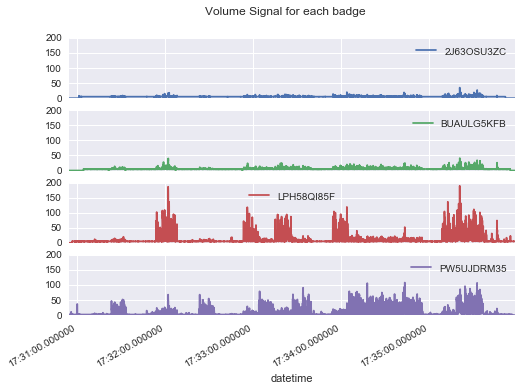

In [6]:
df_meeting.plot(subplots=True,sharey=True,title="Volume Signal for each badge")

The volume signal at each badge consists of the following components 
1. environmental noise (assumed to be stationary and gaussian)
2. attenuated speech from other speakers 
3. badge wearer's speech
4. badge specific constant offset

A threshold on time-domain signal power will be used for the purpose of speech. We actually calculate 2 thresholds for the following:
    1. Environmental noise power (when there are no speakers)
    2. Attenuated speech power (when there is a speaker other than the badge wearer)

In our current approach we assume that there is a single speaker in the meeting at any point in time and the rest of the participants are silent. This assumption is used to remove false positives for speech detection that arise due to attenuated speech of a nearby speaker or some spikes in environmental noise. 

Some assumptions:
    1. The minimum distance between any 2 speakers in a group is assumed to be 3ft.
    2. The smallest time interval for which we would like to be able to a decision on whether speech is present is taken as 1 second.

Some badge wearers may have a very low speaking volume close to either environment noise or attenuated speech levels. This will result in false negatives in speech detection. How low is too low of a speaking volume for a meeting is debatable.

In [7]:
frame_size = 1000 #milliseconds
sampleDelay = 50 # sampling period in milliseconds
median_window_time = 2*60*1000 #milliseconds
median_window = int(median_window_time/sampleDelay) #number of samples
power_window = int(frame_size/sampleDelay) #number of samples
clipping_value = 120

The clipping value is the maximum value of volume above which the signal is assumed to have non-speech external noise. Clip signal values above this

In [8]:
df_meeting = df_meeting.clip(upper=clipping_value)

Each badge's mic output has a constant offset associated with it. The mode or median over a suitably large window (in this case the median window is 2 minutes) gives a good estimate of this offset. We chose to subtract the median over a rolling window for this.

In [9]:
df_median = df_meeting.apply(lambda x:x.rolling(min_periods=1,window=median_window,center=False).median())
df_normalized = df_meeting - df_median

The thresholds mentioned earlier are all based on short-time signal power calculated over a rolling window of 1 second. Power is given by the mean-squared signal value over a given window size. 
$$Power[n] = \frac{1}{power\_window}\sum_{i=n-power\_window+1}^{n}(Signal[n])^{2}$$
The following code calculates the signal power for each of the badges and plots it.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faf14d2f290>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7faf14b41c90>], dtype=object)

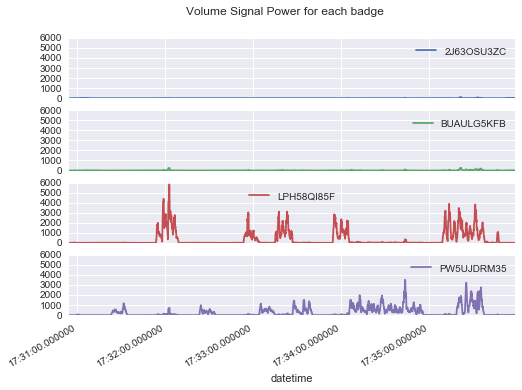

In [10]:
df_energy = df_normalized.apply(np.square)
df_power = df_energy.apply(lambda x:x.rolling(window=power_window, min_periods=1,center=False).mean())
df_power.plot(sharey=True,subplots=True,title="Volume Signal Power for each badge") # Add title here

Assuming a gaussian distribution for the power signals we can assign an power outlier threshold of $\mu_{power}\pm2\sigma_{power}$ (where $\mu_{power}$ is the mean power and $\sigma_{power}$ is the standard deviation) for each of the badge volumes signals.

In [11]:
power_mean = df_power.mean()
power_std = df_power.std()
print 'power_mean : ',power_mean
print 'power_std : ',power_std

power_mean :  member
2J63OSU3ZC      3.638414
BUAULG5KFB     11.561216
LPH58QI85F    358.039606
PW5UJDRM35    281.816434
dtype: float64
power_std :  member
2J63OSU3ZC      9.654779
BUAULG5KFB     26.701476
LPH58QI85F    748.998225
PW5UJDRM35    472.835565
dtype: float64


In [12]:
print 'power_threshold : ',power_mean + 2*power_std

power_threshold :  member
2J63OSU3ZC      22.947973
BUAULG5KFB      64.964167
LPH58QI85F    1856.036055
PW5UJDRM35    1227.487564
dtype: float64


In the test_threshold module we have a function test_threshold which takes df_meeting as the input, goes throught the above steps and returns the power threshold (average) for each badge.

In [13]:
power_threshold = test_threshold(df_meeting)

power_variance :  member
2J63OSU3ZC        93.214766
BUAULG5KFB       712.968794
LPH58QI85F    560998.340984
PW5UJDRM35    223573.471685
dtype: float64
power_mean :  member
2J63OSU3ZC      3.638414
BUAULG5KFB     11.561216
LPH58QI85F    358.039606
PW5UJDRM35    281.816434
dtype: float64
power_threshold = (power_mean + 2*(power_variance)^0.5):  member
2J63OSU3ZC      22.947973
BUAULG5KFB      64.964167
LPH58QI85F    1856.036055
PW5UJDRM35    1227.487564
dtype: float64


The power threshold when the operating environment has no speakers will give us an estimate for the **environmental noise threshold $thr_{env}$ **. Dataset 1 **D1** (NVGWO_1467320376817.txt) where all the badgewearers are silent can be used to obtain this.

Applying this threshold to the volume signal power time series

$$signal[n] = \begin{cases}
  noise, & \text{if } power[n]>thr_{env}, \\
  not\ noise, & \text{otherwise}.
\end{cases}$$

When the signal is not noise it can either be attenuated speech or non-attenuated badge wearer speech. If we consider the case when there is only one speaker and we ignore the speaker's badge data then the rest of the badges record attenuated speech (assuming the minimum distance  between the badge wearers for speech power attenuation is **3 feet**). After ignoring the power samples below $thr_{env}$ we can calculate a power threshold which will give us an estimate for the **attenuated speech threshold $thr_{speech}$**. Dataset 2 **D2** where a single speaker (badge PW5UJDRM35) is present can be used to obtain $thr_{speech}$

Applying this threshold to the volume signal power time series

$$signal[n] = \begin{cases}
  badge\ wearer\ speech, & \text{if } power[n]>thr_{speech}, \\
  not\ speech, & \text{otherwise}.
\end{cases}$$

We therefore set the speech detection threshold in 2 stages. 
* Using a dataset similar to **D1** collected in the operating environment where the badgewearers are silent to set $thr_{env}$
* Using a dataset similar to **D2** collected in the operating environment where there is a single speaker (badge B1) and ignore B1's data to set $thr_{speech}$



**Dataset 1**:
There are 4 badges in this test case. PW5UJDRM35 (who will be the speaker in the next stage) will not be considered when setting the thresholds since only the other 3 badges register silence or attenuated speech. PW5UJDRM35 also has some unknown noise associated with it in the absence of input for this dataset.

In [14]:
input_file_name = '../sample_data/mostly_silence.txt' 
df_meeting = sample2data(input_file_name)
metadata = {}
metadata.update(df_meeting.metadata)
df_meeting=pd.pivot_table(df_meeting.reset_index(),index='datetime',columns='member',values='signal').fillna(value=0)
df_meeting.metadata = metadata

power_variance :  member
2J63OSU3ZC      14.083815
BUAULG5KFB      10.672603
LPH58QI85F       1.666880
PW5UJDRM35    1773.499894
dtype: float64
power_mean :  member
2J63OSU3ZC    0.660883
BUAULG5KFB    0.959447
LPH58QI85F    0.273754
PW5UJDRM35    6.621968
dtype: float64
power_threshold = (power_mean + 2*(power_variance)^0.5):  member
2J63OSU3ZC     8.166565
BUAULG5KFB     7.493237
LPH58QI85F     2.855908
PW5UJDRM35    90.847852
dtype: float64


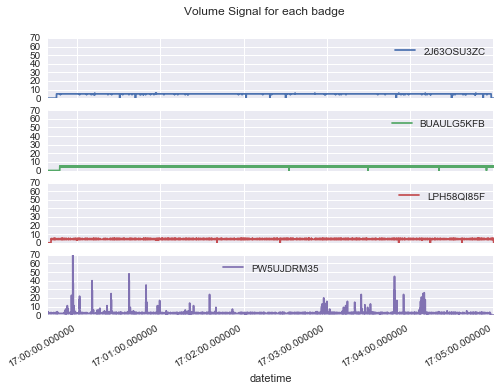

In [15]:
df_meeting.plot(subplots=True,sharey=True,title="Volume Signal for each badge")
power_threshold = test_threshold(df_meeting)

Ignoring PW5UJDRM35 we see that test_threshold gives a maximum power threshold of 8.166 for $thr_{env}$ (Badge PW5UJDRM35 was noisy during the experiment)

**Dataset 2**:
Use the power threshold from dataset 1 as the environmental noise threshold. The test_threshold function takes an argument custom_power_threshold which when set to a non-null value calculates the mean and std for power values above custom_power_threshold to calculate the output power threshold. Set custom_power_threshold to $thr_{env}$ from the previous stage. The output power threshold obtained for the badges with only attenuated speech recorded gives us the speech detection threshold $thr_{speech}$ to be used for the environment.

In [16]:
input_file_name = '../sample_data/one_speaker.txt' #Single speaker
df_meeting = sample2data(input_file_name)
metadata = {}
metadata.update(df_meeting.metadata)
df_meeting=pd.pivot_table(df_meeting.reset_index(),index='datetime',columns='member',values='signal').fillna(value=0)
df_meeting.metadata = metadata

For all power samples greater than custom_power_threshold =  8.166565
power_mean :  member
2J63OSU3ZC     19.975629
BUAULG5KFB     16.952946
LPH58QI85F     15.661860
PW5UJDRM35    145.956466
dtype: float64
power_variance :  member
2J63OSU3ZC       47.371670
BUAULG5KFB       17.374326
LPH58QI85F        5.906498
PW5UJDRM35    21083.362065
dtype: float64
power_threshold = (power_mean + 2*(power_variance)^0.5):  member
2J63OSU3ZC     33.741046
BUAULG5KFB     25.289450
LPH58QI85F     20.522517
PW5UJDRM35    436.358684
dtype: float64


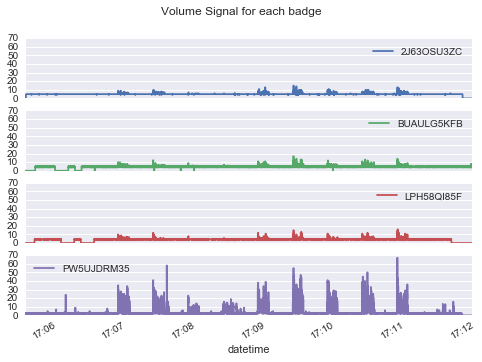

In [17]:
df_meeting.plot(subplots=True,sharey=True,title="Volume Signal for each badge")
power_threshold = test_threshold(df_meeting,custom_power_threshold=8.166565)

In the plot showing volume for each badge we can clearly see that PW5UJDRM35 is the speaker and there is attenuated speech at the other badges at every instant that PW5UJDRM35 is speaking. The maximum power threshold calculated for power samples above $thr_{env}=8.166$ on the non-speaker badges is $thr_{speech} = 33.741$

When attenuated speech power exceeds our speech detection threshold $thr_{speech}$ we will still detect false positives. As mentioned previously, we assume that there is a **single speaker** in the meeting. In case we detect 2 or more badge wearers to be speaking at a certain time interval we choose the badge wearer with the higher volume power value as the speaker for that interval.

The test_threshold module has a function is_speaking. This calculates the volume signal power time series, applies the single speaker assumption and returns a boolean time series for each badge indicating when the power value for a badge exceeds avg_speech_power_threshold (argument passed to the function). When avg_speech_power_threshold = $thr_{speech}$ we get a boolean time series which is True when a badge is speaking.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faf1456a4d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7faf1470fc50>], dtype=object)

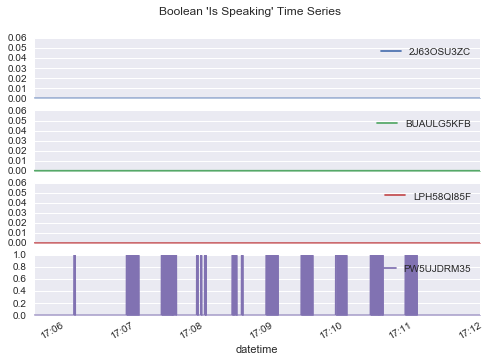

In [18]:
df_is_speech = is_speaking(df_meeting,avg_speech_power_threshold=33.741046)
df_is_speech.plot(kind='area',subplots=True,title="Boolean 'Is Speaking' Time Series")

We can see that only badge PW5UJDRM35 is detected as having speech at regular intervals. df_is_speaking is the boolean time series we will require for the next stage i.e. "stitching"

In addition to having a single speaker we also assume the following:
* A speaker is said to have had a turn (A custom definition for the minimum speaking duration that indicates a contribution to the conversation by the badge wearer) if he/she speaks for a minimum of 2 seconds $(min\_talk\_length)$
* A pause in speech can be a maximum of 0.5 seconds $(min\_gap\_size)$.

Given a boolean value time series for each badge indicating speech/not speech we "stitch" the speaking intervals by:
* Filling in/Ignoring pauses of duration < $min\_gap\_size$ (Equivalent to correcting false negatives)
* Discarding speaking intervals of duration < $min\_talk\_length$

The test_threshold module has a function get_stitched which takes df_is_speaking (a dataframe with each column being a boolean time series associated with a single badge) and returns another set of boolean time series which are "stitched". It takes the arguments $min\_gap\_size$ and $min\_talk\_length$ whose roles have been explained above.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faf14593dd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7faf13c6a110>], dtype=object)

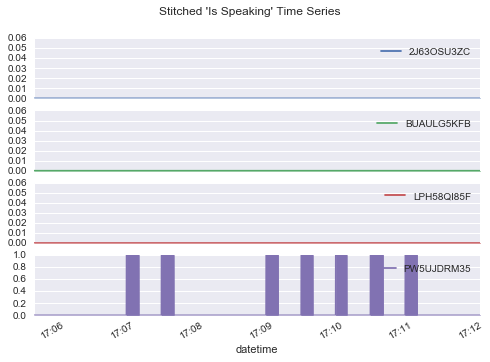

In [19]:
df_stitched = get_stitched(df_is_speech)
df_stitched.plot(kind='area',subplots=True,title="Stitched 'Is Speaking' Time Series")

An issue that we experience with badge wearers having a low speaking volume is patchy detection of speech which may lead to removal of detected speech segments in the stitching phase. Tuning the minimum pause length or speaking duration helps deal with this.

df_stitched is the dataframe that is used to calculate the speech based metrics that we report: airtime, turntaking, ...